# 🚀 Lunar Crater Age Classification: Data Exploration
**Objective**: To systematically explore and characterize the dataset, informing preprocessing strategies and model architecture decisions for classifying craters as **"Fresh"**, **"Old"**, or **"None"**.

## 📁 1. Dataset Structure & Inventory
*Goal: Understand the organization and volume of our data.*

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from  PIL import Image
import numpy as np
import pandas as pd

In [2]:
data_path = Path("../../raw_data")

In [3]:
#Exploring the structure
print("Dataset structure:")
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}:")
    split_path = data_path / split
    for class_name in ["ejecta", "oldcrater", "none"]:
        class_path = split_path / class_name
        num_images = len(list(class_path.glob("*.jpg")))
        print(f" {class_name}: {num_images} images")

Dataset structure:

TRAIN:
 ejecta: 358 images
 oldcrater: 594 images
 none: 2656 images

VAL:
 ejecta: 55 images
 oldcrater: 118 images
 none: 440 images

TEST:
 ejecta: 89 images
 oldcrater: 157 images
 none: 533 images


## 👁️ 2. Visual Sample Gallery
*Goal: Build an intuitive, visual understanding of each class.*

In [4]:
#Create Data frame for visualization
data = []
for split in ["train", "val", "test"]:
    count = len(list((data_path / split / class_name).glob("*.jpg")))
    data.append({"split": split, "class": class_name, "count": count})
df = pd.DataFrame(data)

<Axes: xlabel='class'>

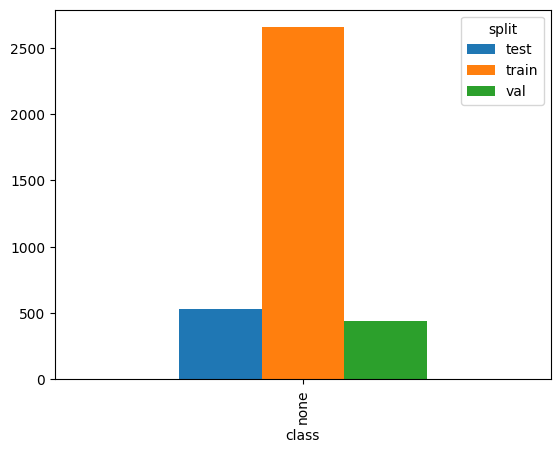

In [5]:
df.pivot(index="class", columns="split", values= "count").plot(kind="bar")

## 📐 3. Technical Image Analysis
*Goal: Determine the technical specifications and necessary transformations.*
**Key Questions:**
- What are the image dimensions (height, width)?
- What is the color mode (RGB, Grayscale)?
- What is the distribution of pixel intensities?

In [6]:
#Image dimensions
sizes = []
for class_name in ["ejecta", "oldcrater", "none"]:
    class_path = data_path / "train" / class_name
    for img_path in list(class_path.glob("*.jpg"))[:3]:
        with Image.open(img_path)as img:
            width, height = img.size
            sizes.append({"class": class_name,
                          "width": width,
                          "height": height,
                          "aspect_ratio": width/height,
                          "filename": img_path.name})
df_sizes = pd.DataFrame(sizes)

In [7]:

df_sizes

,class,width,height,aspect_ratio,filename
0,ejecta,227,227,1.0,M159705621LC_pyr-0144.jpg
1,ejecta,227,227,1.0,M1116046457RC_pyr-0593.jpg
2,ejecta,227,227,1.0,M1178246048RC_pyr-0694.jpg
3,oldcrater,227,227,1.0,M1178352512RC_pyr-0240.jpg
4,oldcrater,227,227,1.0,M1157756910LC_pyr-1398.jpg
5,oldcrater,227,227,1.0,M1095437275RC_pyr-0618.jpg
6,none,227,227,1.0,M119217559LC_pyr-0815.jpg
7,none,227,227,1.0,M1106595881LC_pyr-2050.jpg
8,none,227,227,1.0,M1178352512RC_pyr-0268.jpg


In [ ]:
#Color channel investigation
pixel_stats = []
for class_name in ["ejecta", "oldcrater", "none"]:
    class_path = data_path / "train" / class_name
    for img_path in list(class_path.glob("*.jpg"))[:2]:
        with Image.open(img_path) as img:
            #Convert to numpy array for analysis
            img_array = np.array(img)
            pixel_stats.append({"class": class_name,
                                "mode": img.mode,
                                "shape": img_array.shape,
                                "min": img_array.min(),
                                "max": img_array.max(),
                                "mean": img_array.mean().round(2),
                                "std": img_array.std().round(2),
                                "dtype": img_array.dtype})

df_pixels = pd.DataFrame(pixel_stats)

In [9]:
df_pixels

,class,mode,shape,min,max,mean,std,dtype
0,ejecta,RGB,"(227, 227, 3)",25,255,154.81,28.62,uint8
1,ejecta,RGB,"(227, 227, 3)",17,196,64.41,20.90,uint8
2,oldcrater,RGB,"(227, 227, 3)",97,253,127.18,13.95,uint8
3,oldcrater,RGB,"(227, 227, 3)",0,253,99.03,20.96,uint8
4,none,RGB,"(227, 227, 3)",0,186,85.61,18.53,uint8
5,none,RGB,"(227, 227, 3)",18,215,87.88,16.72,uint8


**Image Dimensions**: All images are `227×227` pixels (confirmed via dataset documentation and sample verification).

**Implications for Preprocessing**:
- ✅ **No resizing required** - images are already uniform
- ✅ **Square aspect ratio** (1:1) - no distortion needed
- ✅ **Compatible** with common CNN architectures

**Preprocessing Decision**: We will use the native `227×227` size for our models.

**✅ Color and Pixel analysis COMPLETE:**
- **Color Mode**: All images are `RGB` (3 channels)
- **Value Range**: `[0, 255]` (uint8) → needs normalization`[0,1]` 
- **Brightness Variability**: "Ejecta" class shows high variance (64-154 mean), suggesting illumination differences

**Preprocessing Decisions:**
1. `ToTensor()` for automatic `[0,255]` → `[0,1]` conversion
2. **Normalization needed** - Will calculate exact mean/std from full dataset
3. **Color preserved** - Use all 3 RGB channels

In [ ]:
#Calculate mean and std for normalization
def calculate_channel_stats(sample_size=100):
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    count = 0

    for class_name in ["ejecta", "oldcrater", "none"]:
        class_path = data_path / "train" / class_name
        for img_path in list(class_path.glob("*.jpg"))[:sample_size//3]:
            with Image.open(img_path) as img:
                img_array = np.array(img) / 255.0     #Normalize to [0,1]
                pixel_sum += img_array.mean(axis=(0,1))
                pixel_sq_sum += (img_array**2).mean(axis=(0,1))
                count += 1

    mean = pixel_sum / count
    std = np.sqrt(pixel_sq_sum / count - mean**2)
    return mean, std

In [12]:
mean, std = calculate_channel_stats(150)
print(f"Mean per channel (R, G, B): {mean.round(4)}")
print(f"Std per channel (R, G, B): {std.round(4)}")

Mean per channel (R, G, B): [0.3306 0.3306 0.3306]
Std per channel (R, G, B): [0.1618 0.1618 0.1618]


In [14]:
#For DataLoader
normalization_stats = {"mean": list(mean.round(4)),
                       "std": list(std.round(4))}

**Calculated from 150-image sample (50 per class):**
- **Mean (R, G, B)**: `[0.3306, 0.3306, 0.3306]` -> low mean: the surface is dark gray on average
- **Standard Deviation (R, G, B)**: `[0.1618, 0.1618, 0.1618]` -> low std: Relatively low contrast accross the dataset
- **Key Insight**: Identical values across RGB channels → lunar images are effectively **grayscale**. This suggests we could potentially convert to single-channel later for efficiency.

# Data preprocessing pipeline

In [19]:
#Imports and setup
import random
import numpy as np
from pathlib import Path
from PIL import Image
from typing import List, Tuple, Dict
import json
import os

In [23]:
#Constants for exploration
IMAGE_SIZE = (227, 227)
NORM_MEAN = [0.3306, 0.3306, 0.3306]
NORM_STD = [0.1618, 0.1618, 0.1618]
CLASS_NAMES = ["ejecta", "oldcrater", "none"]

In [ ]:
#---Pre processing functions---
def load_and_validate_image(path: Path) -> np.array:
    """
    Load image and ensure its 227 x 227 RGB
    Returns: Numpy array shape (227,227,3)

    Args:
        Path to the .jpg file

    Returns:
        NumPy array of shape (227, 227, 3) with dtype uint8 (0-255)
    """
    with Image.open(path) as img:
        #Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert("RGB")

        #Check size
        if img.size != IMAGE_SIZE:
            raise ValueError(f"Image {path.name} is {img.size}, expected {IMAGE_SIZE}")

        return np.array(img) #Shape (227, 227, 3), dtype: uint8

In [30]:
ejecta_path = data_path / "train" / "ejecta"
test_image_path = list(ejecta_path.glob("*.jpg"))[0]

#Call Function
image_array = load_and_validate_image(test_image_path)
#Check results:
image_array.shape, image_array.dtype, image_array.min(), image_array.max(), image_array.mean()

((227, 227, 3),
 dtype('uint8'),
 np.uint8(25),
 np.uint8(255),
 np.float64(154.81435696403966))

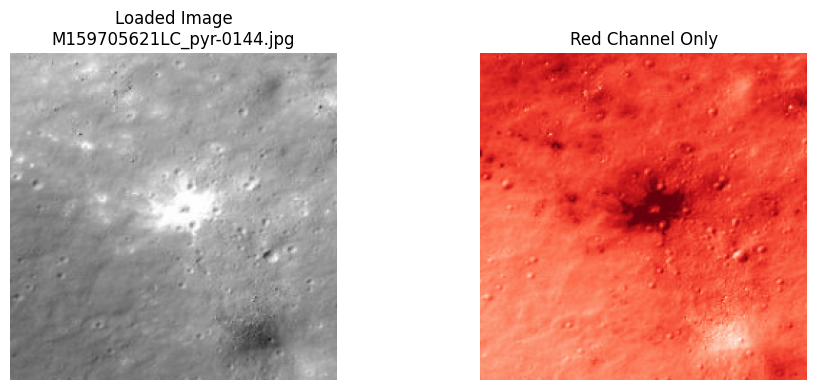

In [ ]:
# 5. Quick visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Show original image
axes[0].imshow(image_array)
axes[0].set_title(f"Loaded Image\n{test_image_path.name}")
axes[0].axis('off')

# Show one channel (Red) to verify structure
axes[1].imshow(image_array[:, :, 0], cmap='Reds')
axes[1].set_title("Red Channel Only")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def normalize_image(image_array: np.ndarray) -> np.array:
    """
    Applies z-score normalization to lunar crater images
    Converts [0, 255] range -> normalized range ~[-2, 2]
    Centers data around 0 (mean = 0, std = 1)
    Helps model to focus on crater features, not brightness

    Formula:
        1. Scale: img_float = img_array / 255.0
        2. Normalize: img_normalized = (img_float - 0.3306) / 0.1618

    Args:
        img_array: NumPy array
    """
